**1. Importing Google Drive**

In [1]:
# ================================
# 1. Mount Google Drive (optional)
# ================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2. Installing Requirements**

In [ ]:
!pip install torch torchvision torchaudio
!pip install scikit-learn pandas numpy matplotlib tqdm
!pip install shap
!pip install umap-learn
!pip install --upgrade --force-reinstall torch torchvision torchaudio

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


**3. Preprocessing**

In [ ]:
import os, glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

DATA_CSV_DIR = "CIC-IDS2018-CSV"  # change to your CSV folder
OUT_DIR = "processed_cicids2017"

os.makedirs(OUT_DIR, exist_ok=True)

all_files = glob.glob(os.path.join(DATA_CSV_DIR, "*.csv"))
if len(all_files) == 0:
    print("No CSV files found in", DATA_CSV_DIR)
else:
    dfs = [pd.read_csv(f) for f in all_files]
    data = pd.concat(dfs, ignore_index=True)
    # Convert object columns to numeric labels
    for c in data.columns:
        if data[c].dtype == 'object':
            try:
                data[c] = LabelEncoder().fit_transform(data[c].astype(str))
            except:
                data[c] = data[c].astype('category').cat.codes
    # Features & labels
    if "Label" not in data.columns:
        raise ValueError("No 'Label' column found in CSVs.")
    X = data.drop("Label", axis=1).values.astype(np.float32)
    y = LabelEncoder().fit_transform(data["Label"].values)
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    np.save(os.path.join(OUT_DIR, "X_train.npy"), X_train)
    np.save(os.path.join(OUT_DIR, "Y_train.npy"), y_train)
    np.save(os.path.join(OUT_DIR, "X_test.npy"), X_test)
    np.save(os.path.join(OUT_DIR, "Y_test.npy"), y_test)
    print(f"Saved processed files in {OUT_DIR}")


No CSV files found in CIC-IDS2017-CSV


**4. Dataloader**

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

DATA_CSV_DIR = "CIC-IDS2018-CSV"  # change to your CSV folder
OUT_DIR = "processed_cicids2018"

class NpyFlowDataset(torch.utils.data.Dataset):
    def __init__(self, folder, mode='train'):
        if mode=='train':
            self.X = np.load(os.path.join(folder,'X_train.npy'))
            self.Y = np.load(os.path.join(folder,'Y_train.npy'))
        else:
            self.X = np.load(os.path.join(folder,'X_test.npy'))
            self.Y = np.load(os.path.join(folder,'Y_test.npy'))
        self.X = self.X.astype(np.float32)
        self.Y = self.Y.astype(np.int64)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.Y[idx])

def make_dataloader(folder, split='train', batch_size=64, shuffle=True, num_workers=2):
    ds = NpyFlowDataset(folder, split=split)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True)


**5. Checking Number of Classes**

In [ ]:
import numpy as np

# Correct paths (NO labels.npy exists)
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/nids_ood_research/src/preprocess_cicids2018/Y_train.npy")
y_test  = np.load("/content/drive/MyDrive/Colab Notebooks/nids_ood_research/src/preprocess_cicids2018/Y_test.npy")

# Combine to check all labels
labels = np.concatenate([y_train, y_test])

print("Unique labels:", np.unique(labels))
print("Number of classes:", len(np.unique(labels)))

Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Number of classes: 15


**6. Baseline**

Loaded NPY shapes:
X_train: (1981520, 78)
Y_train: (1981520,)
X_test: (849223, 78)
Y_test: (849223,)

AUROC (macro-ovr): 0.9952355757881767

Binary AUROC could not be computed.

Classification Report:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99    681929
           1       0.99      0.36      0.53       590
           2       1.00      0.98      0.99     38408
           3       0.99      0.89      0.94      3088
           4       0.98      0.91      0.94     69322
           5       0.90      0.93      0.91      1650
           6       0.93      0.98      0.95      1739
           7       0.98      0.98      0.98      2381
           8       1.00      1.00      1.00         3
           9       0.00      0.00      0.00        11
          10       0.87      0.98      0.92     47679
          11       0.96      0.94      0.95      1769
          12       0.90      0.06      0.11       452
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00       196

    accuracy                           0.98    849223
   macro avg       0.76      0.67      0.68    849223
weighted avg       0.98   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    681929
           1       0.96      0.37      0.54       590
           2       1.00      1.00      1.00     38408
           3       0.94      0.96      0.95      3088
           4       0.91      0.99      0.95     69322
           5       0.87      0.85      0.86      1650
           6       0.86      0.96      0.91      1739
           7       1.00      0.98      0.99      2381
           8       0.00      0.00      0.00         3
           9       0.75      0.27      0.40        11
          10       0.91      1.00      0.95     47679
          11       0.94      0.91      0.93      1769
          12       1.00      0.06      0.11       452
          13       0.00      0.00      0.00         6
          14       1.00      0.03      0.06       196

    accuracy                           0.98    849223
   macro avg       0.81      0.62      0.64    849223
weighted avg       0.98   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99    681929
           1       0.97      0.36      0.53       590
           2       1.00      1.00      1.00     38408
           3       0.99      0.96      0.97      3088
           4       0.94      0.99      0.97     69322
           5       0.88      0.98      0.93      1650
           6       0.96      0.99      0.98      1739
           7       0.99      0.98      0.99      2381
           8       1.00      1.00      1.00         3
           9       1.00      0.27      0.43        11
          10       0.99      1.00      0.99     47679
          11       0.81      0.98      0.89      1769
          12       0.98      0.10      0.18       452
          13       0.00      0.00      0.00         6
          14       1.00      0.03      0.06       196

    accuracy                           0.99    849223
   macro avg       0.90      0.71      0.73    849223
weighted avg       0.99   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    681929
           1       0.61      0.64      0.62       590
           2       1.00      1.00      1.00     38408
           3       0.99      0.96      0.98      3088
           4       0.94      1.00      0.97     69322
           5       0.87      0.99      0.92      1650
           6       0.97      0.98      0.97      1739
           7       0.99      0.98      0.99      2381
           8       0.00      0.00      0.00         3
           9       0.40      0.18      0.25        11
          10       0.99      1.00      0.99     47679
          11       0.96      0.96      0.96      1769
          12       0.98      0.10      0.18       452
          13       0.00      0.00      0.00         6
          14       1.00      0.03      0.06       196

    accuracy                           0.99    849223
   macro avg       0.78      0.65      0.66    849223
weighted avg       0.99   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    681929
           1       0.98      0.37      0.54       590
           2       1.00      1.00      1.00     38408
           3       0.98      0.96      0.97      3088
           4       0.97      0.99      0.98     69322
           5       0.89      0.98      0.94      1650
           6       0.96      0.98      0.97      1739
           7       0.99      0.99      0.99      2381
           8       1.00      1.00      1.00         3
           9       0.25      0.36      0.30        11
          10       0.98      1.00      0.99     47679
          11       0.93      0.98      0.95      1769
          12       0.98      0.10      0.18       452
          13       0.00      0.00      0.00         6
          14       0.60      0.03      0.06       196

    accuracy                           0.99    849223
   macro avg       0.83      0.72      0.72    849223
weighted avg       0.99   

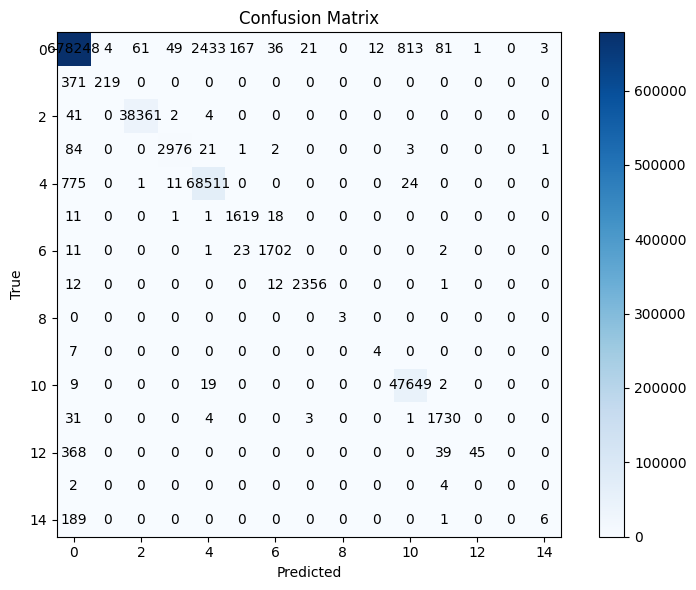

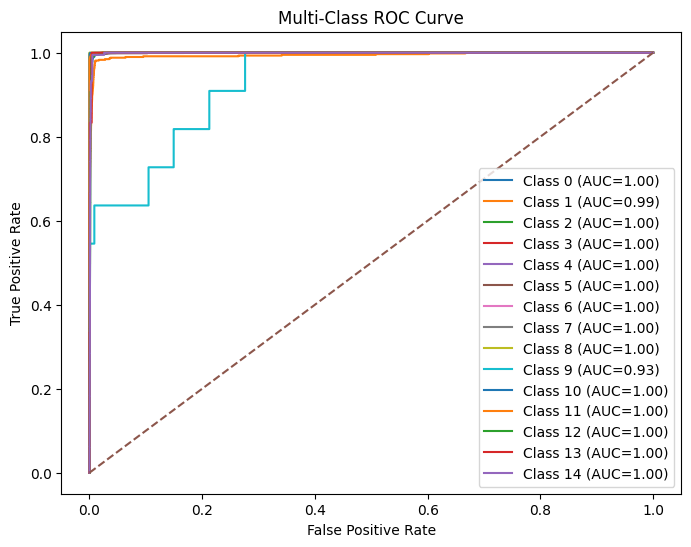

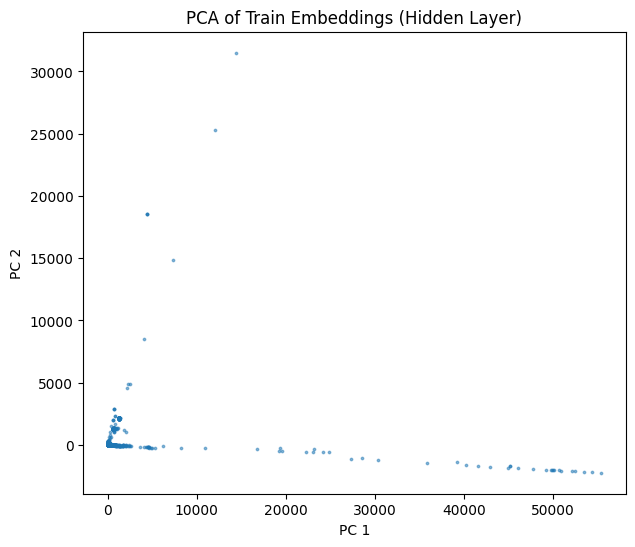

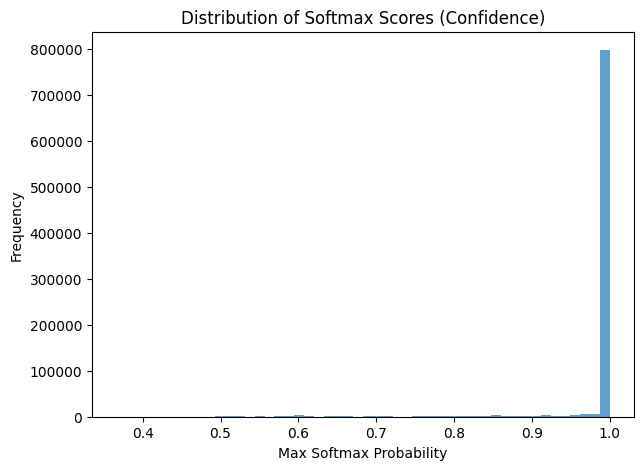

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

# =========================
# Dataset for NPY files
# =========================
class NPYDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# =========================
# MLP Model
# =========================
class BaselineMLP(nn.Module):
    def __init__(self, input_dim, hidden=256, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden//2), nn.ReLU(),
            nn.Linear(hidden//2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# =========================
# Training Function
# =========================
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

# =========================
# Evaluation (AUROC + basic metrics)
# =========================
def eval_ood(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            probs = F.softmax(logits, dim=1).cpu().numpy()

            all_probs.append(probs)
            all_labels.append(y.numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    # MULTI-CLASS AUROC
    auc_value = roc_auc_score(
        all_labels,
        all_probs,
        multi_class='ovr',
        average='macro'
    )

    print("\nAUROC (macro-ovr):", auc_value)

    # ===== BINARY AUROC (Benign vs Attack) =====
    # Treat class 0 = benign, others = attack
    bin_labels = (all_labels != 0).astype(int)
    bin_scores = 1 - probs[:, 0]   # high score = attack

    try:
        bin_auc = roc_auc_score(bin_labels, bin_scores)
        print("\nBinary AUROC (Benign vs Attack):", bin_auc)
    except:
        bin_auc = None
        print("\nBinary AUROC could not be computed.")

    # Convert to predicted classes for metrics
    preds = np.argmax(all_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(all_labels, preds))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, preds))

    return auc_value, all_probs, all_labels, preds

# =========================
# Plotting Function
# =========================
#def plot_results(all_labels, preds, probs):  CHANGE HERE
def plot_results(all_labels, preds, probs, X_train, model, device):
    num_classes = probs.shape[1]

    # -------- CONFUSION MATRIX --------
    cm = confusion_matrix(all_labels, preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()

    # ---- FIX: ADD VALUES ON SQUARES ----
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                    ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

    # -------- ROC CURVE --------
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    fpr, tpr, roc_auc = {}, {}, {}

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC={roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title("Multi-Class ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# -------- PCA Train --------
def pca_train_embeddings(model, X_train, device):
    model.eval()

    # Extract features from the hidden layer
    with torch.no_grad():
        #x = torch.tensor(X_train, dtype=torch.float32).to(device)  CHANGE HERE
        x = torch.tensor(X_train, dtype=torch.float32).to(device)
        # Forward pass until second layer (before final output)
        hidden = model.net[:-1](x).cpu().numpy()

    # PCA to 2 components
    pca = PCA(n_components=2)
    proj = pca.fit_transform(hidden)

    plt.figure(figsize=(7, 6))
    plt.scatter(proj[:, 0], proj[:, 1], s=3, alpha=0.5)
    plt.title("PCA of Train Embeddings (Hidden Layer)")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()

# -------- Plot Score Distribution --------
def plot_score_distribution(probs):
    max_scores = np.max(probs, axis=1)

    plt.figure(figsize=(7, 5))
    plt.hist(max_scores, bins=50, alpha=0.7)
    plt.title("Distribution of Softmax Scores (Confidence)")
    plt.xlabel("Max Softmax Probability")
    plt.ylabel("Frequency")
    plt.show()

# =========================
# MAIN
# =========================
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/nids_ood_research/src/preprocess_cicids2018"

    # Load NPY datasets
    X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
    X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
    Y_train = np.load(os.path.join(DATA_DIR, "Y_train.npy"))
    Y_test = np.load(os.path.join(DATA_DIR, "Y_test.npy"))

    print("Loaded NPY shapes:")
    print("X_train:", X_train.shape)
    print("Y_train:", Y_train.shape)
    print("X_test:", X_test.shape)
    print("Y_test:", Y_test.shape)

    train_loader = DataLoader(NPYDataset(X_train, Y_train), batch_size=128, shuffle=True)
    test_loader = DataLoader(NPYDataset(X_test, Y_test), batch_size=128, shuffle=False)

    input_dim = X_train.shape[1]
    num_classes = len(np.unique(Y_train))

    model = BaselineMLP(input_dim=input_dim, num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # TRAINING LOOP
    for ep in range(5):
        loss = train(model, train_loader, optimizer, device)
        auc_value, probs, labels, preds = eval_ood(model, test_loader, device)
        print(f"Epoch {ep}: Loss={loss:.4f}  AUROC={auc_value:.4f}")

    # Save model
    torch.save(model.state_dict(), "baseline_model.pth")
    print("Saved model as baseline_model.pth")

    # PLOTTING (after final epoch)
    #plot_results(labels, preds, probs)  CHANGE HERE
    plot_results(labels, preds, probs, X_train, model, device)

    # PCA of Train Embeddings
    pca_train_embeddings(model, X_train, device)

    # Score Distribution
    plot_score_distribution(probs)

if __name__ == "__main__":
    main()


**7. Improved**

In [1]:
# improved_pipeline_memory_friendly.py
# Fully corrected + memory safe + syntax clean
# Author: Adapted for Farhan (NUST) – 2025

import os
import time
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score, f1_score,
    roc_curve
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ---------------------------
# CONFIG
# ---------------------------
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/nids_ood_research/src/preprocess_cicids2018"
RESULT_DIR = "/content/drive/MyDrive/Colab Notebooks/nids_ood_research/src"
os.makedirs(RESULT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRINT_DEVICE = True

# hyperparameters
LATENT_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 64        # lowered for memory
EPOCHS = 15
LR = 1e-3
WEIGHTED_CE = True
USE_FOCAL = True
FOCAL_GAMMA = 2.0
OVERSAMPLE = True      # via WeightedRandomSampler (SAFE)
USE_MAHALANOBIS = False
SEED = 42

MODEL_PATH = os.path.join(RESULT_DIR, "improved_model_final.pth")
TRAIN_EMBS_FILE = os.path.join(RESULT_DIR, "train_embs.npy")
TRAIN_LABELS_FILE = os.path.join(RESULT_DIR, "train_labels.npy")
SCORES_FILE = os.path.join(RESULT_DIR, "scores_improved.npy")
LABELS_FILE = os.path.join(RESULT_DIR, "labels_improved.npy")
LOGITS_FILE = os.path.join(RESULT_DIR, "logits_improved.npy")
PREDS_FILE = os.path.join(RESULT_DIR, "preds_improved.npy")

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ---------------------------
# Utils
# ---------------------------
def safe_load(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found")
    return np.load(path)

def softmax_np(logits):
    e = np.exp(logits - logits.max(axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

# ---------------------------
# Dataset Wrapper
# ---------------------------
class NPYDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ---------------------------
# Models
# ---------------------------
class EncoderMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, latent_dim)
        )
    def forward(self, x):
        return self.net(x)

class Classifier(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, num_classes=2):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(latent_dim, latent_dim//2),
            nn.ReLU(),
            nn.Linear(latent_dim//2, num_classes)
        )
    def forward(self, z):
        return self.head(z)

# ---------------------------
# Losses
# ---------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, reduction="none")
        pt = torch.exp(-ce)
        loss = ((1 - pt)**self.gamma) * ce
        return loss.mean() if self.reduction == "mean" else loss.sum()

# ---------------------------
# Mahalanobis (optional)
# ---------------------------
class MahalanobisStats:
    def fit(self, embs, labels):
        classes = np.unique(labels)
        self.means = {}
        all_embs = []

        for c in classes:
            zc = embs[labels == c]
            self.means[c] = zc.mean(axis=0)
            all_embs.append(zc)

        all_embs = np.concatenate(all_embs, axis=0)
        cov = np.cov(all_embs, rowvar=False)
        cov += np.eye(cov.shape[0]) * 1e-6
        self.inv_cov = np.linalg.pinv(cov)

    def mahal(self, Z):
        scores = []
        for zi in Z:
            ds = []
            for c, mu in self.means.items():
                diff = zi - mu
                ds.append(diff @ self.inv_cov @ diff.T)
            scores.append(min(ds))
        return np.array(scores)

# ---------------------------
# Metrics
# ---------------------------
def compute_metrics_binary_from_scores(scores, labels):
    binary_labels = (labels != 0).astype(int)
    auroc = roc_auc_score(binary_labels, scores)

    fpr, tpr, thr = roc_curve(binary_labels, scores)
    idx = np.where(fpr <= 0.01)[0]
    recall_at_1p = tpr[idx[-1]] if len(idx) > 0 else tpr[0]

    return auroc, recall_at_1p

# ---------------------------
# Sampler for Memory-Safe Oversampling
# ---------------------------
def make_sampler(y_train):
    if not OVERSAMPLE:
        return None

    y = np.array(y_train)
    class_counts = np.bincount(y)
    class_counts = np.maximum(class_counts, 1)

    class_weights = 1.0 / class_counts
    sample_weights = class_weights[y]

    sampler = WeightedRandomSampler(
        weights=torch.DoubleTensor(sample_weights),
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

# ---------------------------
# Training & Evaluation
# ---------------------------
def train_one_epoch(encoder, clf, loader, optimizer, loss_fn):
    encoder.train(); clf.train()
    running_loss = 0
    total = 0

    pbar = tqdm(loader, desc="Train", ncols=120, leave=False)
    for xb, yb in pbar:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        z = encoder(xb)
        logits = clf(z)
        loss = loss_fn(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        total += xb.size(0)

        pbar.set_postfix(loss=running_loss / total)

    return running_loss / total

def evaluate(encoder, clf, loader):
    encoder.eval(); clf.eval()

    logits_list = []
    embs_list = []
    labels_list = []

    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Eval", ncols=120, leave=False):
            xb = xb.to(DEVICE)

            z = encoder(xb)
            logits = clf(z)

            logits_list.append(logits.cpu().numpy().astype(np.float32))
            embs_list.append(z.cpu().numpy().astype(np.float32))
            labels_list.append(yb.numpy())

    logits = np.concatenate(logits_list, axis=0)
    embs = np.concatenate(embs_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    preds = np.argmax(logits, axis=1)
    probs = softmax_np(logits)

    return logits, probs, preds, labels, embs

# ---------------------------
# Main Pipeline
# ---------------------------
def run_pipeline():

    print("\nDEVICE:", DEVICE)

    # load data
    X_train = safe_load(os.path.join(DATA_DIR, "X_train.npy"))
    y_train = safe_load(os.path.join(DATA_DIR, "Y_train.npy"))
    X_test  = safe_load(os.path.join(DATA_DIR, "X_test.npy"))
    y_test  = safe_load(os.path.join(DATA_DIR, "Y_test.npy"))

    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)

    # scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    train_ds = NPYDataset(X_train, y_train)
    test_ds = NPYDataset(X_test, y_test)

    sampler = make_sampler(y_train)

    if sampler is not None:
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler)
    else:
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    num_classes = int(y_train.max()) + 1

    # model
    input_dim = X_train.shape[1]
    encoder = EncoderMLP(input_dim).to(DEVICE)
    clf = Classifier(latent_dim=LATENT_DIM, num_classes=num_classes).to(DEVICE)

    # loss
    if WEIGHTED_CE:
        class_counts = np.bincount(y_train, minlength=num_classes)
        class_counts = np.maximum(class_counts, 1)
        weights = (1 / class_counts)
        weights = weights / weights.sum() * num_classes
        weights = torch.tensor(weights, dtype=torch.float32).to(DEVICE)
        ce_loss = nn.CrossEntropyLoss(weight=weights)
    else:
        ce_loss = nn.CrossEntropyLoss()

    loss_fn = FocalLoss(gamma=FOCAL_GAMMA) if USE_FOCAL else ce_loss

    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + list(clf.parameters()), lr=LR
    )

    # training loop
    print("\nStarting training...\n")
    for epoch in range(1, EPOCHS + 1):
        train_loss = train_one_epoch(encoder, clf, train_loader, optimizer, loss_fn)

        logits_val, probs_val, preds_val, labels_val, embs_val = evaluate(
            encoder, clf, test_loader
        )

        energy_scores = np.logaddexp.reduce(logits_val, axis=1)
        auroc, recall_1p = compute_metrics_binary_from_scores(energy_scores, labels_val)
        acc = accuracy_score(labels_val, preds_val)
        macro_f1 = f1_score(labels_val, preds_val, average="macro")

        print(f"Epoch {epoch}/{EPOCHS}  loss={train_loss:.4f}  acc={acc:.4f}  "
              f"macroF1={macro_f1:.4f}  AUROC={auroc:.4f}  recall@1%FPR={recall_1p:.4f}")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # final evaluation
    logits_test, probs_test, preds_test, labels_test, embs_test = evaluate(
        encoder, clf, test_loader
    )
    energy_scores = np.logaddexp.reduce(logits_test, axis=1)

    if USE_MAHALANOBIS:
        print("Fitting Mahalanobis...")
        encoder.eval()
        Z_train = []
        Y_train = []

        with torch.no_grad():
            for xb, yb in DataLoader(train_ds, batch_size=BATCH_SIZE):
                z = encoder(xb.to(DEVICE)).cpu().numpy().astype(np.float32)
                Z_train.append(z)
                Y_train.append(yb.numpy())

        Z_train = np.concatenate(Z_train, axis=0)
        Y_train = np.concatenate(Y_train, axis=0)

        m = MahalanobisStats()
        m.fit(Z_train, Y_train)
        maha = m.mahal(embs_test)
        final_scores = energy_scores - maha
    else:
        final_scores = energy_scores

    bin_labels = (labels_test != 0).astype(int)
    auroc_final = roc_auc_score(bin_labels, final_scores)

    fpr, tpr, thr = roc_curve(bin_labels, final_scores)
    idx = np.where(fpr <= 0.01)[0]
    recall_1p = tpr[idx[-1]] if len(idx) else tpr[0]

    acc_final = accuracy_score(labels_test, preds_test)
    macrof1_final = f1_score(labels_test, preds_test, average="macro")

    print("\n=== FINAL METRICS ===")
    print("Binary AUROC :", auroc_final)
    print("Recall@1%FPR:", recall_1p)
    print("Accuracy    :", acc_final)
    print("Macro F1    :", macrof1_final)

    # save results
    np.save(LOGITS_FILE, logits_test)
    np.save(LABELS_FILE, labels_test)
    np.save(PREDS_FILE, preds_test)
    np.save(SCORES_FILE, final_scores)

    # embeddings save
    encoder.eval()
    Z_train2, Y_train2 = [], []
    with torch.no_grad():
        for xb, yb in DataLoader(train_ds, batch_size=BATCH_SIZE):
            z = encoder(xb.to(DEVICE)).cpu().numpy().astype(np.float32)
            Z_train2.append(z)
            Y_train2.append(yb.numpy())

    Z_train2 = np.concatenate(Z_train2, axis=0)
    Y_train2 = np.concatenate(Y_train2, axis=0)

    np.save(TRAIN_EMBS_FILE, Z_train2)
    np.save(TRAIN_LABELS_FILE, Y_train2)

    # PCA plot
    pca = PCA(n_components=2)
    emb2 = pca.fit_transform(Z_train2)

    plt.figure(figsize=(8,6))
    sc = plt.scatter(emb2[:, 0], emb2[:, 1], c=Y_train2, s=6, cmap="tab20")
    plt.colorbar(sc)
    plt.title("PCA of Train Embeddings")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULT_DIR, "pca_train_embs.png"))
    plt.close()

    # Save model
    torch.save({
        "encoder": encoder.state_dict(),
        "classifier": clf.state_dict(),
        "scaler_mean": scaler.mean_,
        "scaler_var": scaler.var_
    }, MODEL_PATH)

    print("\nModel + artifacts saved.")

    return {
        "auroc": float(auroc_final),
        "recall_1%": float(recall_1p),
        "accuracy": float(acc_final),
        "macro_f1": float(macrof1_final),
    }


if __name__ == "__main__":
    results = run_pipeline()
    print("\nRESULT SUMMARY:", results)



DEVICE: cuda

Starting training...



Epoch 1/15  loss=0.0817  acc=0.9164  macroF1=0.5025  AUROC=0.6389  recall@1%FPR=0.0119


Epoch 2/15  loss=0.0624  acc=0.9402  macroF1=0.5924  AUROC=0.6133  recall@1%FPR=0.0587


Epoch 3/15  loss=0.0568  acc=0.9441  macroF1=0.5502  AUROC=0.4262  recall@1%FPR=0.0015


Epoch 4/15  loss=0.0515  acc=0.9454  macroF1=0.6010  AUROC=0.4994  recall@1%FPR=0.0001


Epoch 5/15  loss=0.0479  acc=0.9412  macroF1=0.5623  AUROC=0.5822  recall@1%FPR=0.0001


Epoch 6/15  loss=0.0465  acc=0.9492  macroF1=0.6268  AUROC=0.7016  recall@1%FPR=0.0004


Epoch 7/15  loss=0.0457  acc=0.9509  macroF1=0.6000  AUROC=0.4483  recall@1%FPR=0.0000


Epoch 8/15  loss=0.0436  acc=0.9517  macroF1=0.6303  AUROC=0.4956  recall@1%FPR=0.0001


Epoch 9/15  loss=0.0421  acc=0.9320  macroF1=0.6022  AUROC=0.4484  recall@1%FPR=0.0379


Epoch 10/15  loss=0.0418  acc=0.9306  macroF1=0.6092  AUROC=0.4408  recall@1%FPR=0.1493


Epoch 11/15  loss=0.0410  acc=0.9375  macroF1=0.5988  AUROC=0.4934  recall@1%FPR=0.1835


Epoch 12/15  loss=0.0406  acc=0.9251  macroF1=0.5746  AUROC=0.4936  recall@1%FPR=0.2446


Epoch 13/15  loss=0.0405  acc=0.9502  macroF1=0.5995  AUROC=0.4777  recall@1%FPR=0.2091


Epoch 14/15  loss=0.0392  acc=0.9293  macroF1=0.6174  AUROC=0.5853  recall@1%FPR=0.1689


Epoch 15/15  loss=0.0390  acc=0.9462  macroF1=0.6131  AUROC=0.7768  recall@1%FPR=0.2558



=== FINAL METRICS ===
Binary AUROC : 0.7768213449639134
Recall@1%FPR: 0.25575932191232204
Accuracy    : 0.9461743264136746
Macro F1    : 0.6130758067192779

Model + artifacts saved.

RESULT SUMMARY: {'auroc': 0.7768213449639134, 'recall_1%': 0.25575932191232204, 'accuracy': 0.9461743264136746, 'macro_f1': 0.6130758067192779}


**Visualization**


===== MULTI-CLASS CLASSIFICATION METRICS =====
Accuracy     : 0.9462
Macro F1     : 0.6131


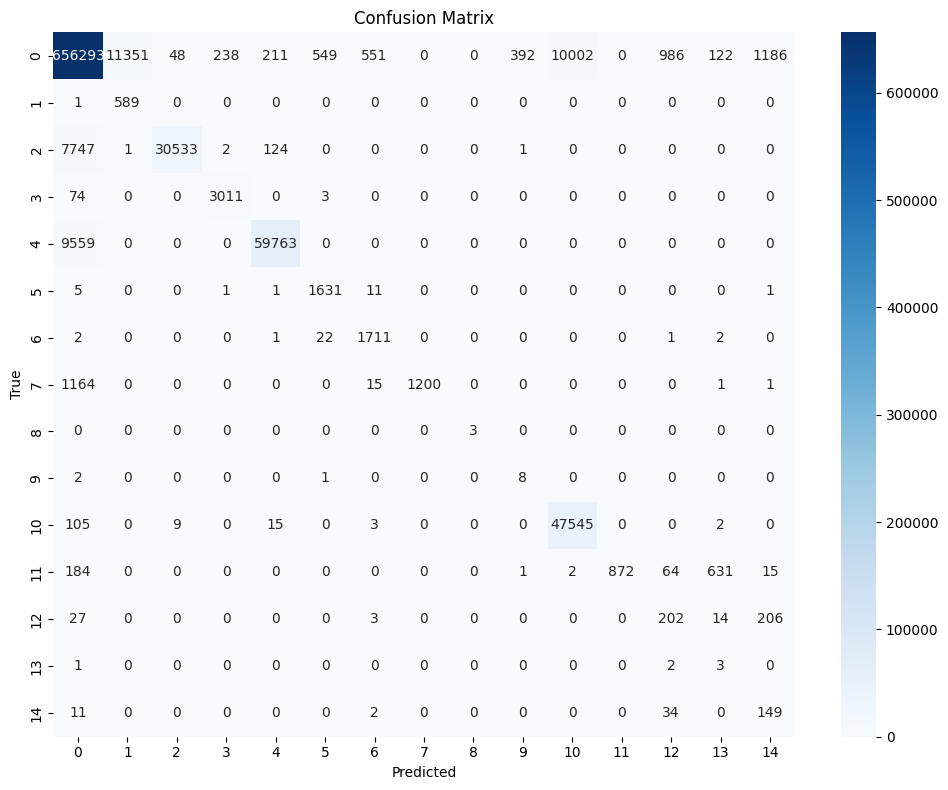


===== OOD DETECTION METRICS =====
AUROC                : 0.7768
Recall @ 1% FPR      : 0.2558


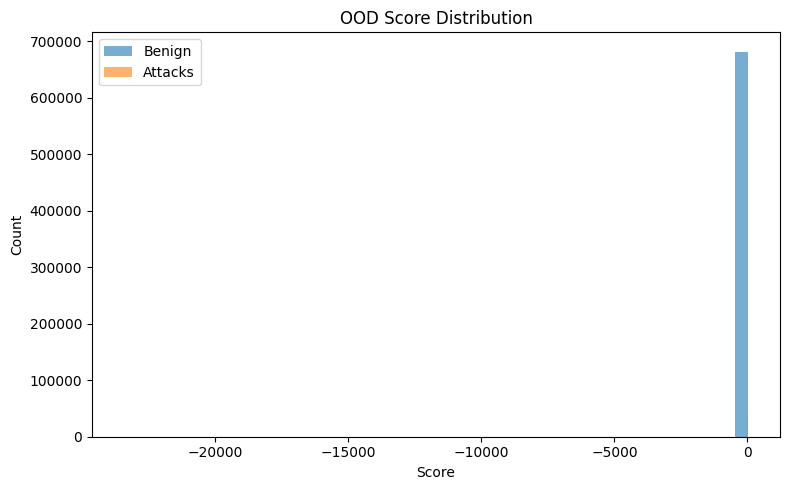

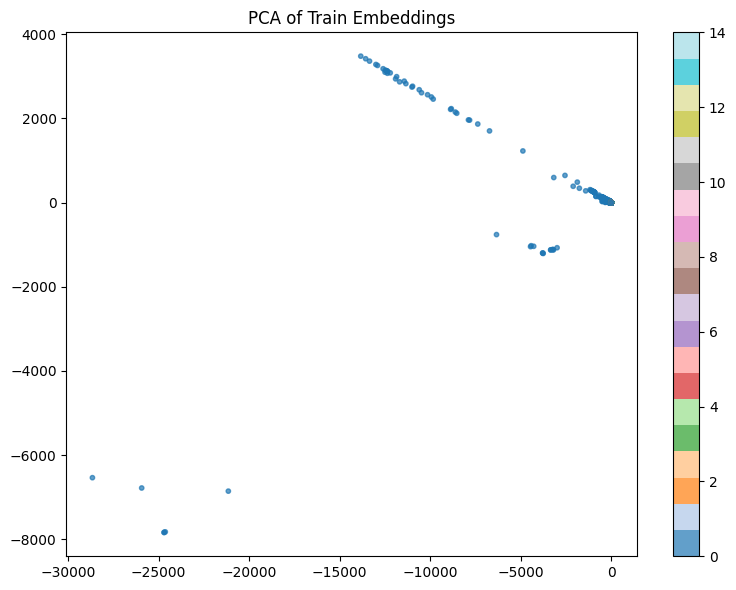

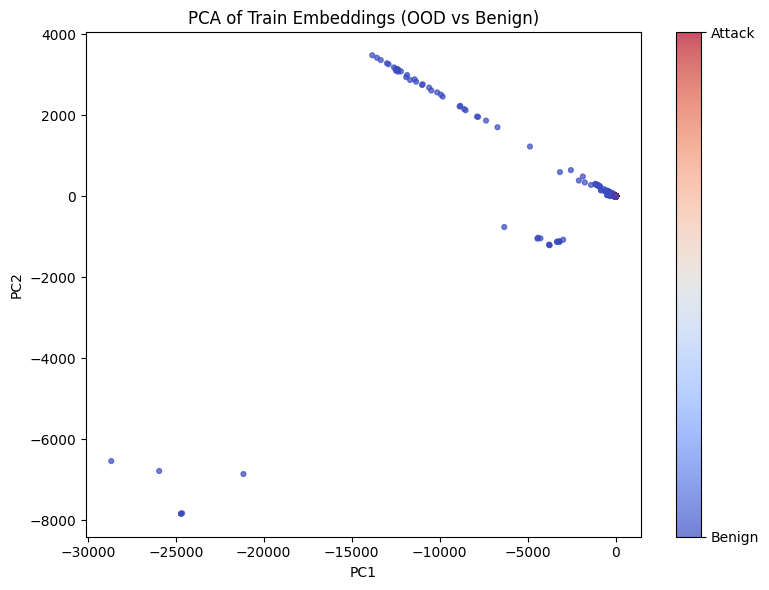


All visualizations generated successfully!


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_curve
)
from sklearn.decomposition import PCA

# =============================
#  PATH CONFIG
# =============================
RESULT_DIR = "/content/drive/MyDrive/Colab Notebooks/nids_ood_research/src"

TRAIN_EMBS_FILE   = os.path.join(RESULT_DIR, "train_embs.npy")
TRAIN_LABELS_FILE = os.path.join(RESULT_DIR, "train_labels.npy")
TEST_SCORES_FILE  = os.path.join(RESULT_DIR, "scores_improved.npy")
LOGITS_FILE       = os.path.join(RESULT_DIR, "logits_improved.npy")
LABELS_FILE       = os.path.join(RESULT_DIR, "labels_improved.npy")
PREDS_FILE        = os.path.join(RESULT_DIR, "preds_improved.npy")

# =============================
#  Utility
# =============================
def load_npy(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    return np.load(path)

def softmax_np(logits):
    e = np.exp(logits - logits.max(axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

# =============================
#  Plots
# =============================
def plot_score_distribution(scores, labels):
    plt.figure(figsize=(8,5))
    plt.hist(scores[labels==0], bins=50, alpha=0.6, label="Benign")
    plt.hist(scores[labels!=0], bins=50, alpha=0.6, label="Attacks")
    plt.legend()
    plt.title("OOD Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("score_distribution.png", dpi=300)
    plt.show()

    plt.figure(figsize=(10,6))
    plt.hist(scores_benign, bins=100, alpha=0.6, label="Benign", log=True)
    plt.hist(scores_attack, bins=100, alpha=0.6, label="Attacks", log=True)
    plt.xlabel("Score")
    plt.ylabel("Count (log scale)")
    plt.legend()
    plt.title("OOD Score Distribution (Log Scale)")
    plt.show()

    sns.kdeplot(scores_benign, label="Benign", fill=True)
    sns.kdeplot(scores_attack, label="Attacks", fill=True)
    plt.xlabel("Score")
    plt.title("KDE Score Density (Benign vs Attacks)")
    plt.legend()
    plt.show()

def plot_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=300)
    plt.show()

def plot_pca(embeddings, labels):
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap="tab20", s=10, alpha=0.7)
    plt.colorbar(scatter)
    plt.title("PCA of Train Embeddings")
    plt.tight_layout()
    plt.savefig("pca_train_embeddings.png", dpi=300)
    plt.show()

def plot_pca_ood(embeddings, labels):
    """
    PCA of embeddings colored by OOD (0 = benign, 1 = attack)
    """
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(embeddings)

    # Binary labels: 0 = benign, 1 = attack
    ood_labels = (labels != 0).astype(int)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(
        emb_2d[:,0], emb_2d[:,1],
        c=ood_labels, cmap="coolwarm", s=12, alpha=0.7
    )
    cbar = plt.colorbar(scatter, ticks=[0,1])
    cbar.ax.set_yticklabels(['Benign', 'Attack'])
    plt.title("PCA of Train Embeddings (OOD vs Benign)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig("pca_train_embeddings_ood.png", dpi=300)
    plt.show()

# =============================
#  OOD Metrics
# =============================
def compute_ood_metrics(scores, labels):
    y_true = (labels != 0).astype(int)
    auroc = roc_auc_score(y_true, scores)
    fpr, tpr, thr = roc_curve(y_true, scores)
    idx = np.where(fpr <= 0.01)[0]
    recall_1p = tpr[idx[-1]] if len(idx) else tpr[0]
    return auroc, recall_1p

# =============================
#  MAIN
# =============================
def main():
    # Load data
    train_embs   = load_npy(TRAIN_EMBS_FILE)
    train_labels = load_npy(TRAIN_LABELS_FILE)
    test_scores  = load_npy(TEST_SCORES_FILE)
    logits_test  = load_npy(LOGITS_FILE)
    labels_test  = load_npy(LABELS_FILE)
    preds_test   = load_npy(PREDS_FILE)

    # Multi-class classification metrics
    acc = accuracy_score(labels_test, preds_test)
    macro_f1 = f1_score(labels_test, preds_test, average="macro")
    print("\n===== MULTI-CLASS CLASSIFICATION METRICS =====")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Macro F1     : {macro_f1:.4f}")
    plot_confusion(labels_test, preds_test)

    # OOD detection metrics (using energy scores)
    energy_scores = np.logaddexp.reduce(logits_test, axis=1)
    auroc, recall_1p = compute_ood_metrics(energy_scores, labels_test)
    print("\n===== OOD DETECTION METRICS =====")
    print(f"AUROC                : {auroc:.4f}")
    print(f"Recall @ 1% FPR      : {recall_1p:.4f}")
    plot_score_distribution(energy_scores, labels_test)

    # PCA of train embeddings
    plot_pca(train_embs, train_labels)

    # PCA of OOD train embeddings
    plot_pca_ood(train_embs, train_labels)

    print("\nAll visualizations generated successfully!")

if __name__ == "__main__":
    main()
